In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_rho_amp = pd.read_csv("../lab_data/Digitized_Resistivity_Data.csv").values
data_rho_phase = pd.read_csv("../lab_data/digitized_phase_curves_phase.csv").values
data_rho_phase_smooth = pd.read_csv("../lab_data/smoothed_phase_curves.csv").values

In [3]:
# pd.read_csv("../lab_data/Digitized_Resistivity_Data.csv")

In [4]:
freqs = data_rho_amp[:,::2]
rhos = data_rho_amp[:,1::2]

In [5]:
freqs_phase = data_rho_phase[:,::2]
rhos_phase = data_rho_phase[:,1::2]

In [6]:
freqs_phase_smooth = data_rho_phase_smooth[:,::2]
rhos_phase_smooth = data_rho_phase_smooth[:,1::2]

In [7]:
from scipy.interpolate import UnivariateSpline, LSQUnivariateSpline
freqs_phase.shape

(1038, 6)

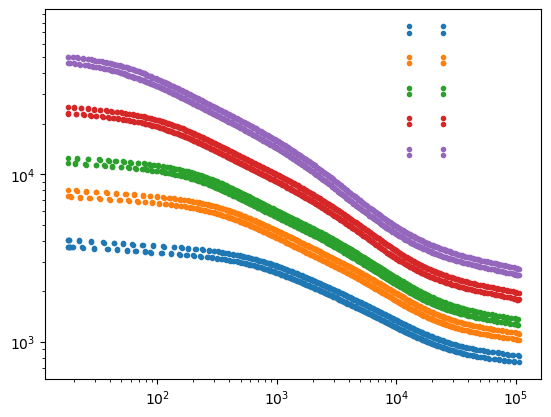

In [8]:
for ii in range(5):
    plt.loglog(freqs[:,ii], rhos[:,ii], '.')

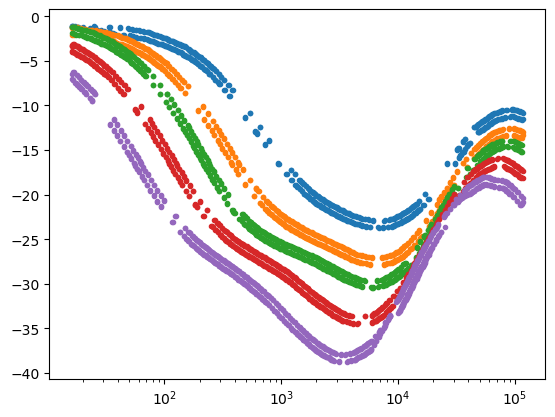

In [9]:
for ii in range(5):
    plt.semilogx(freqs_phase[:,ii], rhos_phase[:,ii], '.')
# for ii in range(5):
#     plt.semilogx(freqs_phase_smooth[:,ii], rhos_phase_smooth[:,ii], '.')    

In [10]:
# Moving average smoothing function
def moving_average(x, y, window_size=3):
    y_smooth = np.convolve(y, np.ones(window_size)/window_size, mode='valid')
    x_smooth = x[(window_size - 1)//2: -(window_size // 2)]
    return x_smooth, y_smooth

300
300
300
300
300


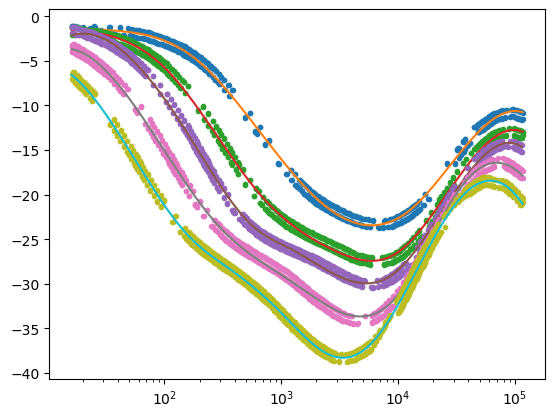

In [11]:
rho_phase_final = np.zeros((300, 5))
for ii in range(5):
    freq, phase = freqs_phase[:, ii], rhos_phase[:, ii]
    freq = freq[~np.isnan(freq)]
    phase = phase[~np.isnan(phase)]
    
    # Sort and remove duplicates
    sort_idx = np.argsort(freq)
    freq_sorted = freq[sort_idx]
    phase_sorted = phase[sort_idx]
    freq_sorted_avg, phase_sorted_avg = moving_average(freq_sorted, phase_sorted)
    # Apply smoothing spline in log-frequency space
    log_freq = np.log10(freq_sorted_avg)
    spline = UnivariateSpline(log_freq, phase_sorted_avg, s=0.1 * len(freq_sorted))  # smoothness factor
    log_freq_dense = np.linspace(log_freq.min(), log_freq.max(), 300)
    phase_smooth = spline(log_freq_dense)
    rho_phase_final[:, ii] = phase_smooth
    # # Store result
    # smoothed_curves[label] = (10**log_freq_dense, phase_smooth)
    
    # Plot
    print (len(log_freq_dense))
    plt.semilogx(freqs_phase[:,ii], rhos_phase[:,ii], '.')
    plt.semilogx(10**log_freq_dense, phase_smooth)

In [12]:
from scipy.signal import medfilt

# Apply median filter to a 1D array
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

# Smooth a 1D signal (e.g., resistivity) with a Gaussian filter
# smoothed_y = gaussian_filter1d(y, sigma=2)

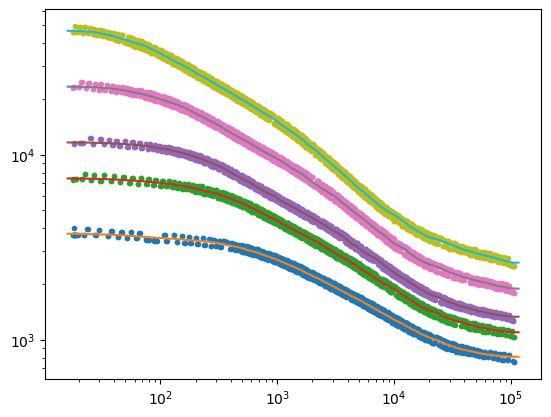

In [166]:
rho_amp_final = np.zeros((300, 5))
for ii in range(5):

    freq, rho_amp = freqs[:, ii], rhos[:, ii]
    freq = freq[~np.isnan(freq)]
    rho_amp = rho_amp[~np.isnan(rho_amp)]
    rho_amp_filt = medfilt(rho_amp, kernel_size=7)  # kernel size must be odd

    # Sort and remove duplicates
    sort_idx = np.argsort(freq)
    freq_sorted = freq[sort_idx]
    rho_amp_sorted = rho_amp_filt[sort_idx]
    log_freq = np.log10(freq_sorted)
    rho_amp_avg = gaussian_filter1d(rho_amp_sorted, sigma=15, mode='reflect')
    f_int = interp1d(log_freq, rho_amp_avg, bounds_error=False, fill_value='extrapolate', kind='nearest')
    rho_amp_smooth = f_int(log_freq_dense)
    # spline = UnivariateSpline(log_freq_dense, rho_amp_smooth, s=100 * len(freq_sorted))  # smoothness factor
    f_int_tmp = interp1d(log_freq_dense, rho_amp_smooth, kind='cubic')
    rho_amp_final[:, ii] = f_int_tmp(log_freq_dense)
    # # # Plot
    # # print (len(log_freq_dense))
    plt.loglog(freq_sorted, rho_amp_sorted, '.')
    plt.semilogx(10**log_freq_dense, rho_amp_final[:, ii])

In [14]:
rho_final = rho_amp_final * np.exp(1j*np.deg2rad(rho_phase_final))

In [15]:
# rho_amp_final = np.exp(1j*np.deg2rad(rho_phase_final)) * abs(rho_final)

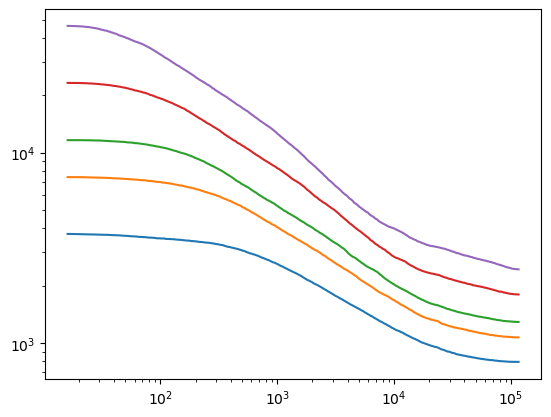

In [16]:
plt.loglog(10**log_freq_dense, rho_final.real)

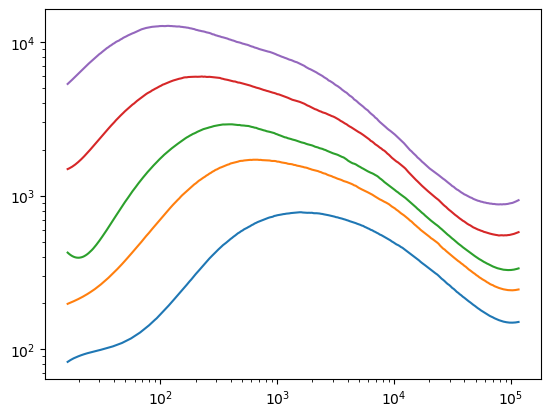

In [17]:
plt.loglog(10**log_freq_dense, -rho_final.imag)

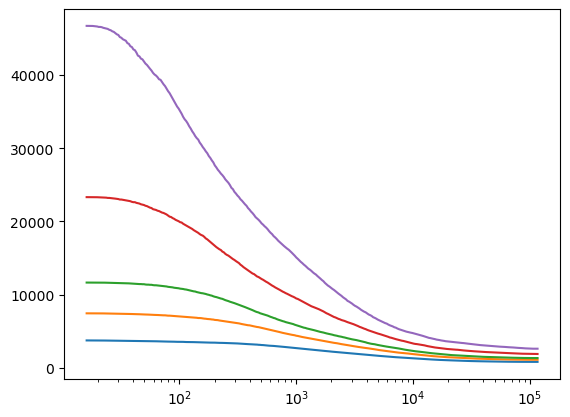

In [18]:
plt.semilogx(10**log_freq_dense, rho_amp_final)

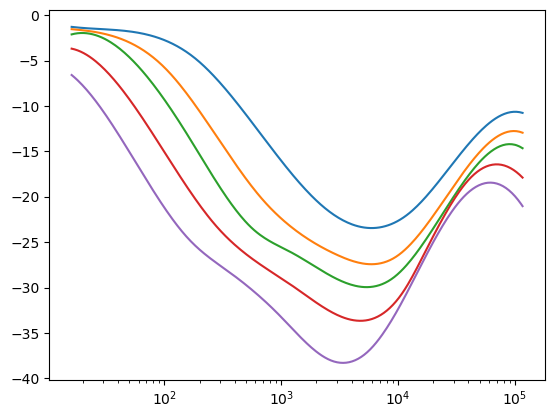

In [19]:
plt.semilogx(10**log_freq_dense, rho_phase_final)

In [20]:
import numpy as np
from scipy.integrate import fixed_quad
from scipy.special import roots_legendre as _cached_roots_legendre

def piecewise_ramp_fast(
    step_func, t_off, t_currents, currents, x, w,
    eps=1e-10
):
    """
    Computes response from piecewise linear current waveform
    with a single pulse. This basically evaluates the convolution
    between dI/dt and step-off response.

    step_func: function handle to evaluate step-off response
    t_off: time channels when the current is off
    t_shift: t_off + T/2
    currents: input source currents
    n: Gaussian quadrature order
    """
    n = x.size
    dt = np.diff(t_currents)
    dI = np.diff(currents)
    dIdt = dI/dt
    nt = t_currents.size
    pulse_time = t_currents.max()

    # Create a bunch of memory in C and use broadcasting
    t_lag = pulse_time - t_currents
    t_lag_expand = (np.repeat(t_lag[1:, np.newaxis], t_off.size, 1)).T
    t_lag_3D = np.repeat(t_lag_expand[:, :, np.newaxis], n, 2)
    t3D = t_lag_3D + t_off[:, np.newaxis, np.newaxis]
    # Gauss-Legendre part.
    # Expand time shifts and origin to 3D with G-L points
    inds = t3D[:,:,0] < 0.
    # Compute dt for both on-time and off-time
    # off-time f(t, t+t0)
    # on-time f(0, t+t0)
    dt_on_off = np.tile(dt, (t_off.size, 1))
    dt_on_off[inds] = (dt + t3D[:,:,0])[inds]
    t3D[inds,:] = 0.

    y = dt_on_off[:,:,np.newaxis] * (0.5 * (x + 1.0)) + t3D

    # Evaluate and weight G-L values with current waveform
    f = w * step_func(np.log10(y))
    s = f.sum(axis = 2) * 0.5 * dt_on_off

    response = np.sum(s * -dIdt, axis=1)

    return response

In [21]:
import digital_filter
import numpy as np
from scipy.interpolate import interp1d

In [238]:
time = np.logspace(-6, -3)
wt, tbase, omega_int = digital_filter.setFrequency(time)

In [239]:
outs = []
for ii in range(5):
    omega = 10**log_freq_dense * np.pi * 2
    out, _ = digital_filter.transFiltInterp(rho_final[:,ii], wt, tbase, omega, omega_int, time)
    outs.append(out)

np.float64(46393.30968878792)

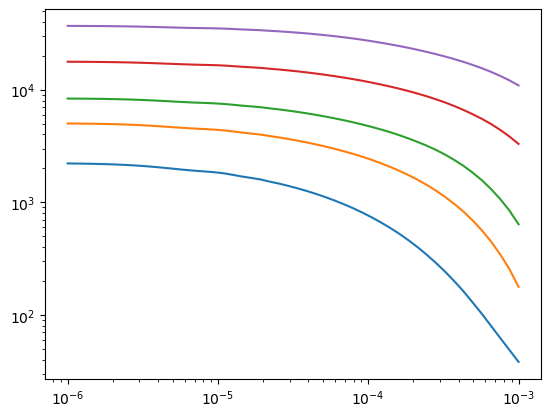

In [240]:
for out in outs:
    plt.loglog(time, out)    

6.8e-01, 7.0e-05, 5.5e-01
6.9e-01, 1.7e-04, 6.6e-01
7.3e-01, 2.5e-04, 6.6e-01
7.9e-01, 4.1e-04, 5.9e-01
8.2e-01, 6.8e-04, 5.8e-01


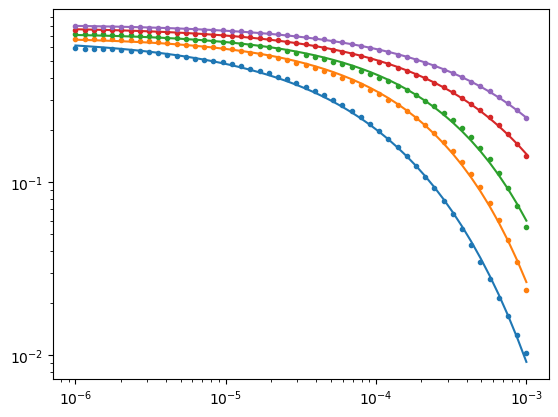

In [322]:
from scipy.optimize import curve_fit
import numpy as np

# Example model function
def f(t, log_eta, log_tau, log_c):
    eta = np.exp(log_eta)
    tau = np.exp(log_tau)
    c = np.exp(log_c)
    return np.log10(eta * (np.exp(-(t / tau)**c)))  # replace with your actual model


for ii in range(5):
    # Example observed data
    t_obs = time.copy()
    rho_dc = rho_final[0,ii].real
    y_obs = np.log10(outs[ii]/rho_dc)    
    # Initial guesses for parameters
    initial_guess = np.log(np.array([10**y_obs[0], 1e-5, 1.]))

    # Fit the model to the data
    popt, pcov = curve_fit(f, t_obs, y_obs, p0=initial_guess)

    # Extract fitted parameters
    log_eta_fit, log_tau_fit, log_c_fit = popt
    plt.loglog(t_obs, 10**f(t_obs, log_eta_fit, log_tau_fit, log_c_fit), color=f'C{ii}')
    plt.loglog(t_obs, 10**y_obs, '.', color=f'C{ii}')
    print(f"{np.exp(log_eta_fit):.1e}, {np.exp(log_tau_fit):.1e}, {np.exp(log_c_fit):.1e}") 

In [321]:
y_obs[0]

np.float64(-0.10047066677203076)

In [260]:
def f_cole(t, sigma_inf, eta, tau, c):
    wt, tbase, omega_int = digital_filter.setFrequency(t)
    sigma = sigma_inf - sigma_inf*eta /(1+(1j*omega_int*tau)**c)
    out, _ = digital_filter.transFilt(1./sigma, wt, tbase, omega_int, t)        
    return out

In [296]:
def f_cole(omega, sigma_inf, eta, tau, c):
    sigma = sigma_inf - sigma_inf*eta /(1+(1j*omega*tau)**c)
    return sigma

In [307]:
f = np.logspace(-1, 5)
sigma = f_cole(f*np.pi*2, 1, 0.1, 1e-5, 0.8)

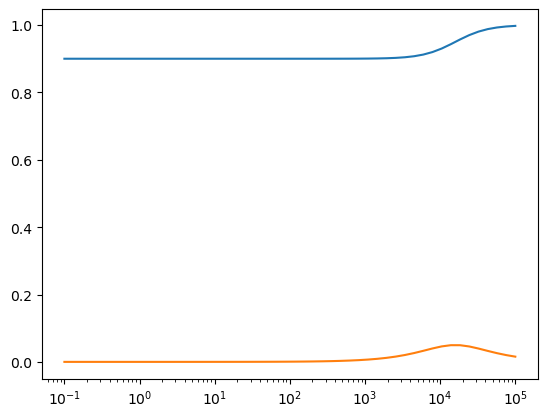

In [308]:
plt.semilogx(f, sigma.real)
plt.semilogx(f, sigma.imag)

In [312]:
sigma_inf = 1e-3
eta = 0.9
rho_dc = 1./(sigma_inf*(1-eta))
rho_dc * eta

9000.000000000002

In [311]:
rho_dc

10000.000000000002

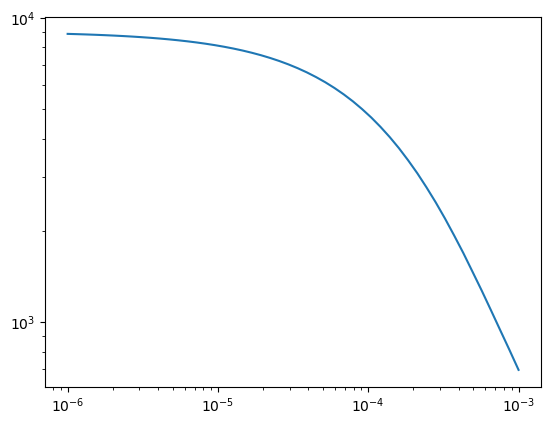

In [280]:
plt.loglog(time, f_cole(time, 1e-3, 0.9, 1e-5, 0.8))

In [257]:
digital_filter.transFilt?

Signature: digital_filter.transFilt(hz, wt, tbase, omega_int, t, tol=1e-12)
Docstring: Compute Step-off responses by Fast Hankel Transform (FHT) with cosine filters
File:      ~/Project/gsc_tem_permafrost/notebooks/digital_filter.py
Type:      function

In [ ]:
# Example model function
def f(t, log_eta, log_tau, log_c):
    eta = np.exp(log_eta)
    tau = np.exp(log_tau)
    c = np.exp(log_c)
    return np.log10(eta * (np.exp(-(t / tau)**c)))  # replace with your actual model
